In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import cv2
import imageio
import numpy as np
import tensorflow as tf
from src import model, align
from src.facenet.src import facenet
import matplotlib.pyplot as plt
import time

%matplotlib inline

/Users/s180893/Documents/Personal/Code/Projects/ng-lab-face-recognition/venv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Facial Recognition with Facenet
  
The workflow for recognizing an image is:
1. Detect face in image
2. Crop the face
3. Feed the cropped image to facenet
4. Compare ([L2 Norm](http://mathworld.wolfram.com/L2-Norm.html)) the output embeddings to embeddings for every other face in the database
5. Find the face in the embeddings that is closest to the input image.
6. If the distance is below some threshold, then we have a match.
7. If not, the face is an unknown one (we don't have it in the database).

First, load the model and initialize the aligner.

In [3]:
sess = tf.InteractiveSession()
model.load_model()

Model directory: ./saved_models/model_vggface2
Metagraph file: model-20180402-114759.meta
Checkpoint file: model-20180402-114759.ckpt-275
INFO:tensorflow:Restoring parameters from ./saved_models/model_vggface2/model-20180402-114759.ckpt-275


In [4]:
aligner = align.MtcnnAligner()

Read an image to go through the process of computing embeddings.

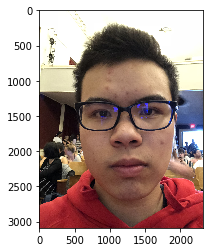

In [5]:
jason = imageio.imread("./test_images/jason.jpg")
plt.imshow(jason)

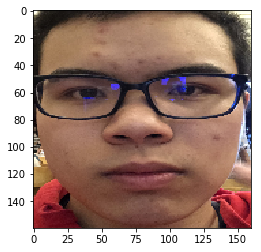

In [6]:
jason_face = aligner.align_and_crop_face(jason)
plt.imshow(jason_face)

In [7]:
jason_embeddings = model.get_embeddings(jason_face)

The alignment operation is **too slow**. Let's time them.

In [8]:
start = time.time()
aligner.align_and_crop_face(jason)
print("{} seconds ellapsed.".format(time.time() - start))

5.682396173477173 seconds ellapsed.


In [9]:
start = time.time()
model.get_embeddings(jason_face)
print("{} seconds ellapsed.".format(time.time() - start))

0.0993349552154541 seconds ellapsed.


Alignment is definitely the bottleneck. A potential option is to use the [yolo](https://pjreddie.com/darknet/yolo/) network to detect faces since it's probably faster. Look into Allan Zelener's [yad2k](https://github.com/allanzelener/YAD2K), a tool that converts darknet (what yolo was built in) models and weights to keras/tensorflow.

Let's load other faces now.

In [10]:
jason2 = imageio.imread("./test_images/jason2.jpg")
jason3 = imageio.imread("./test_images/jason3.jpg")
cumberbatch = imageio.imread("./test_images/cumberbatch.jpg")
sam = imageio.imread("./test_images/sam.jpg")
sam2 = imageio.imread("./test_images/sam2.jpg")
sam3 = imageio.imread("./test_images/sam3.jpg")

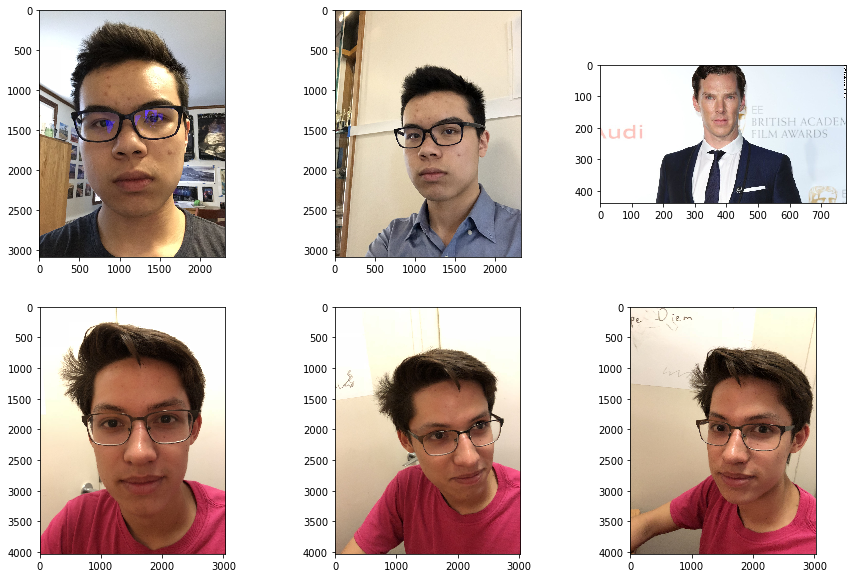

In [11]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax[0, 0].imshow(jason2)
ax[0, 1].imshow(jason3)
ax[0, 2].imshow(cumberbatch)
ax[1, 0].imshow(sam)
ax[1, 1].imshow(sam2)
ax[1, 2].imshow(sam3)

In [12]:
jason2_face = aligner.align_and_crop_face(jason2)
jason3_face = aligner.align_and_crop_face(jason3)
cumberbatch_face = aligner.align_and_crop_face(cumberbatch)
sam_face = aligner.align_and_crop_face(sam)
sam2_face = aligner.align_and_crop_face(sam2)
sam3_face = aligner.align_and_crop_face(sam3)

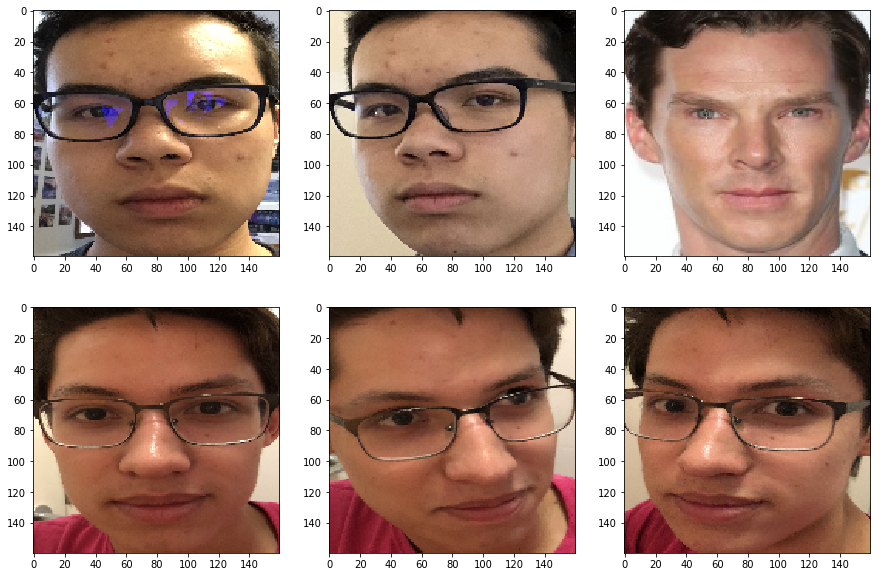

In [13]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax[0, 0].imshow(jason2_face)
ax[0, 1].imshow(jason3_face)
ax[0, 2].imshow(cumberbatch_face)
ax[1, 0].imshow(sam_face)
ax[1, 1].imshow(sam2_face)
ax[1, 2].imshow(sam3_face)

In [14]:
jason2_embeddings = model.get_embeddings(jason2_face)
jason3_embeddings = model.get_embeddings(jason3_face)
cumberbatch_embeddings = model.get_embeddings(cumberbatch_face)
sam_embeddings = model.get_embeddings(sam_face)
sam2_embeddings = model.get_embeddings(sam2_face)
sam3_embeddings = model.get_embeddings(sam3_face)

Now we look at the distance (L2 Norm) between the embeddings.

In [15]:
def distance(embeddings1, embeddings2, metric="l2_norm"):
    """Calculates distance between embeddings
    
    Metric can be 'l2_norm' or 'cosine_similarity'
    """
    
    # In the facenet library, distance metric 0 is l2norm while distance
    # metric 1 is cosine similarity.
    if metric == "l2_norm":
        # Implementing L2 Norm myself because the facenet.distance doesn't take
        # square root after summing the differences. In practice this doesn't
        # matter as long as we are consistent, but I don't want to be confusing.
        return np.linalg.norm(embeddings2 - embeddings1)
    elif metric == "cosine_similarity":
        return facenet.distance(embeddings1, embeddings2, distance_metric=1)[0]
    else:
        raise ("metric must be either l2_norm or cosine_similarity"
               ", instead received '{}'.".format(metric))

In [16]:
print("Jason and Jason2", distance(jason_embeddings, jason2_embeddings))
print("Jason and Jason3", distance(jason_embeddings, jason3_embeddings))
print("Jason and Benedict Cumberbatch", distance(jason_embeddings, cumberbatch_embeddings))
print("Jason and Sam", distance(jason_embeddings, sam_embeddings))
print("Jason and Sam2", distance(jason_embeddings, sam2_embeddings))
print("Jason and Sam3", distance(jason_embeddings, sam3_embeddings))
print("Sam and Sam2", distance(sam_embeddings, sam2_embeddings))
print("Sam and Sam3", distance(sam_embeddings, sam3_embeddings))

Jason and Jason2 0.15848342
Jason and Jason3 0.23601179
Jason and Benedict Cumberbatch 0.3148276
Jason and Sam 0.26285747
Jason and Sam2 0.28006074
Jason and Sam3 0.17875652
Sam and Sam2 0.23580894
Sam and Sam3 0.20967296


Now we can build a list of known faces and classify new faces by comparing their embeddings to ones we have here.

In [17]:
embeddings_database = np.array([
    jason_embeddings,
    cumberbatch_embeddings,
    sam_embeddings,
])

names = [
    "Jason Chen",
    "Benedict Cumberbatch",
    "Sam Henderson"
]

In [18]:
def distance_from_all(embeddings):
    diff = np.subtract(embeddings_database, embeddings)
    norm = np.sqrt(np.sum(np.square(diff), axis=-1))
    return np.squeeze(norm)

In [19]:
def classify(embeddings):
    distance = distance_from_all(embeddings)
    
    if np.amin(distance) > 0.25:
        return "Unknown"
    
    name_index = np.argmin(distance)
    return names[name_index]

In [20]:
def print_classification(name, result):
    print("Classifying {}'s face as {}.".format(name, result))

In [21]:
print_classification("Jason Chen", classify(jason3_embeddings))
print_classification("Sam Henderson", classify(sam2_embeddings))

Classifying Jason Chen's face as Jason Chen.
Classifying Sam Henderson's face as Sam Henderson.


It doesn't seem to correctly identify the third picture of Sam's face. Does he really look like me?

In [22]:
print_classification("Sam Henderson", classify(sam3_embeddings))

Classifying Sam Henderson's face as Jason Chen.


Let's try and classifying an unknown image.

In [23]:
unknown_person = imageio.imread("./test_images/unknown.jpg")
unknown_face = aligner.align_and_crop_face(unknown_person)
unknown_embeddings = model.get_embeddings(unknown_face)

In [24]:
classify(unknown_embeddings)

'Unknown'